In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [2]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [10]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = read_tracer_and_zos_from_budget(datadir("model/tracers_sigma2_1p5/CM4Xp125_ssp585_tracers_sigma2_2020-2024.zarr"))

/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2020-2024.zarr


In [11]:
ds["density"] = ds.sigma2_l * xr.where(ds.thkcello.fillna(0.0) > 0.0, 1, 0) 
ds["density"] = ds["density"].where(ds["density"] > 0)
ds["density"].attrs["cell_methods"] = ds["thetao"].attrs["cell_methods"]
ds_remap = remap_sigma_to_depth(ds)

no z_i provided
using a default setup
N = 35; H = 6500 meters; eta = 25 meters


In [12]:
ds_remap.thetao.isel(time = 0, yh = 100, xh = 100).compute()

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray 'thetao' (z_l: 35)> Size: 280B
array([        nan,         nan,         nan,         nan,         nan,
        0.92730458,  0.96870312,  1.04496019,  1.20346377,  1.36932445,
        1.49078219,  1.65622014,  1.71487181,  1.96210713,  2.14064008,
        2.45519426,  2.80277443,  3.29864411,  3.83718166,  4.43592842,
        4.95598271,  5.45677211,  5.91327507,  6.44455352,  7.07614287,
        8.58556125, 10.38521177, 13.66658976, 18.07588878, 20.83469544,
       23.13396224, 26.64124475, 28.41122303, 28.46983416, 28.59017202])
Coordinates: (12/13)
    areacello        float64 8B 2.234e+10
    deptho           float32 4B 4.57e+03
    geolat           float64 8B -10.99
    geolon           float64 8B -149.2
    lat              float64 8B -10.99
    lon              float64 8B -149.2
    ...               ...
    wet              float32 4B 1.0
    xh               int64 8B 100
    yh               int64 8B 100
    exp              <U6 24B 'forced'
    time_since_init  object 8B 0271-01-16 12:00:00
  * z_l              (z_l) float64 280B -6.307e+03 -5.922e+03 ... -20.0 10.56
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time:mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [13]:
ds_remap.density.isel(time = 0, yh = 100, xh = 100).compute()

<xarray.DataArray 'density' (z_l: 35)> Size: 280B
array([        nan,         nan,         nan,         nan,         nan,
       36.95715786, 36.9415    , 36.92931891, 36.904     , 36.87932165,
       36.86125   , 36.82489035, 36.812     , 36.76362065, 36.73199836,
       36.67605697, 36.60840128, 36.52132685, 36.42827935, 36.31548702,
       36.21777943, 36.12547703, 36.04158106, 35.94324524, 35.81168578,
       35.57334433, 35.21885379, 34.65602526, 33.97001693, 33.43670352,
       32.81343986, 31.78842341, 31.165     , 31.0552775 , 30.83      ])
Coordinates: (12/13)
    areacello        float64 8B 2.234e+10
    deptho           float32 4B 4.57e+03
    geolat           float64 8B -10.99
    geolon           float64 8B -149.2
    lat              float64 8B -10.99
    lon              float64 8B -149.2
    ...               ...
    wet              float32 4B 1.0
    xh               int64 8B 100
    yh               int64 8B 100
    exp              <U6 24B 'forced'
    time_since_init  object 8B 0271-01-16 12:00:00
  * z_l              (z_l) float64 280B -6.307e+03 -5.922e+03 ... -20.0 10.56
Attributes:
    cell_methods:  area:mean z_l:mean yh:mean xh:mean time:mean

In [15]:
def volume_weighted_average(ds):
    weights = (ds.thkcello * ds.areacello / ds.wet)
    weights = weights.where(ds.thkcello > 0)
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

In [21]:
ds_SO = volume_weighted_average(ds_remap.where(ds_remap.geolat < -50)).compute()

/tmp/ipykernel_256988/1337641156.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])


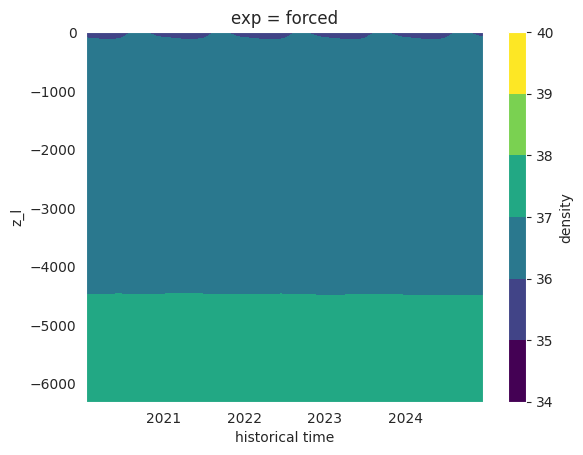

In [18]:
ds_SO.density.T.plot.contourf(vmin = 34, vmax = 40)